In [1]:
!pip install ipympl
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.5 MB/s eta 0:00:00
Mounted at /content/drive


In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [16]:
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.saving import register_keras_serializable

In [2]:


tf.compat.v1.enable_eager_execution()
xfilepath="/content/drive/MyDrive/Colab Notebooks/Copy of inputExpanded.csv"
ypath="/content/drive/MyDrive/Colab Notebooks/Copy of output.npy"

#Load X and Y and expand dimensions
input_data= pd.read_csv(xfilepath)
x= input_data.to_numpy()
y=np.load(ypath)

#Shuffle and split data
m=x.shape[0]
testSplit=0.05
shuffle=np.arange(m)
np.random.shuffle(shuffle)
x=x[shuffle,:]
y=y[shuffle,:]
index=int(np.floor(m*(1-testSplit)))
xTrain=x[0:index,:]
yTrain=y[0:index,:]
xTest=x[index:,:]
yTest=y[index:,:]

In [3]:
print(x.shape, y.shape, xTrain.shape, yTrain.shape, xTest.shape, yTest.shape)

(53959, 93) (53959, 4096) (51261, 93) (51261, 4096) (2698, 93) (2698, 4096)


In [27]:
import sys
# Add the path to your Python files to the system path
sys.path.append('/content/drive/MyDrive/CS 230 Project')
from utilLoss import *
responseModel = keras.models.load_model("/content/drive/MyDrive/CS 230 Project/responseModel.keras")
responseModel.trainable=False
#Normalized MSE of predicted response spectra
@register_keras_serializable()
def spectrum(y,yhat):
    ySpectrum=responseModel(y)
    yhatSpectrum=responseModel(yhat)
    return tf.divide(tf.divide(tf.reduce_mean(tf.square(tf.subtract(ySpectrum,yhatSpectrum))),tf.reduce_mean(tf.square(ySpectrum))+1e-8),0.01)

#Non-tensorflow version of the above
def spectrumNP(y,yhat):
    ySpectrum=responseModel(y)
    yhatSpectrum=responseModel(yhat)
    return np.mean(np.abs(ySpectrum-yhatSpectrum)/ySpectrum,axis=1)

#Normalized MSE of predicted response spectra
@register_keras_serializable()
def spectrumNormalized(y,yhat):
    ySpectrum=responseModel(y)
    ySpectrum=tf.divide(ySpectrum,tf.reduce_mean(ySpectrum,axis=1,keepdims=True))
    yhatSpectrum=responseModel(yhat)
    yhatSpectrum=tf.divide(yhatSpectrum,tf.reduce_mean(yhatSpectrum,axis=1,keepdims=True))
    return tf.reduce_mean(tf.square(tf.subtract(ySpectrum,yhatSpectrum)))

#Relative difference in Arias intensities
@register_keras_serializable()
def arias(y,yhat):
    aly=tf.reduce_sum(tf.square(y))
    alyhat=tf.reduce_sum(tf.square(yhat))
    return tf.divide(tf.abs(tf.subtract(aly,alyhat)),aly+1e-8)

#Non-tensorflow version of the above
def ariasNP(y,yhat):
    aly=np.sum(np.square(y),axis=1)
    alyhat=np.sum(np.square(yhat),axis=1)
    return np.abs(aly-alyhat)/(aly+1e-8)

#Direct MSE comparison of records, normalized
@register_keras_serializable()
def motion(y,yhat):
    return tf.divide(tf.reduce_mean(tf.square(tf.subtract(tf.abs(y),tf.abs(yhat)))),tf.reduce_mean(tf.square(y))+1e-8)

#Direct MSE comparison of records, averaged in 16 bins, normalized, weighted to record start
@register_keras_serializable()
def smearedMotion(y,yhat):
    n=64
    ySmeared=tf.reduce_mean(tf.abs(tf.reshape(y,(n,-1))),axis=1)
    yhatSmeared=tf.reduce_mean(tf.abs(tf.reshape(yhat,(n,-1))),axis=1)
    return tf.divide(tf.reduce_mean(tf.square(tf.subtract(ySmeared,yhatSmeared))),tf.reduce_mean(tf.square(y))+1e-8)

#Non-tensorflow version of the above
def smearedNP(y,yhat):
    n=64
    ySmeared=np.mean(np.abs(np.reshape(y,(n,-1))),axis=1)
    yhatSmeared=np.mean(np.abs(np.reshape(yhat,(n,-1))),axis=1)
    return np.mean(np.abs(ySmeared-yhatSmeared)/np.mean(ySmeared+1e-8))

#Direct MSE comparison of records, averaged in 16 bins, normalized, weighted to record start
@register_keras_serializable()
def biSmearedMotion(y,yhat):
    n=64
    ySmeared=tf.reduce_mean(tf.abs(tf.reshape(y,(n,-1))),axis=1)
    yhatSmeared=tf.reduce_mean(tf.abs(tf.reshape(yhat,(n,-1))),axis=1)
    error=tf.reduce_mean(tf.abs(tf.subtract(ySmeared,yhatSmeared)))
    return tf.reduce_mean([tf.divide(error,tf.reduce_mean(tf.abs(y))+1e-8),tf.divide(error,tf.reduce_mean(tf.abs(yhat))+1e-8)])

#Time of peak acceleration
@register_keras_serializable()
def recordPeak(y,yhat):
    return tf.reduce_max(tf.divide(tf.abs(tf.subtract(tf.argmax(tf.abs(y),axis=1),tf.argmax(tf.abs(yhat),axis=1))),300))

#Custom loss model
@register_keras_serializable()
def responseLoss(y,yhat):
    spectrumLoss=spectrum(y,yhat)
    ariasLoss=arias(y,yhat)
    smearedMotionLoss=smearedMotion(y,yhat)
    return tf.divide(tf.reduce_sum([tf.cast(spectrumLoss,tf.float64),tf.cast(ariasLoss,tf.float64),tf.cast(smearedMotionLoss,tf.float64)]),3.0)

#Full-record Fourier transform MSE loss
@register_keras_serializable()
def fourier(y,yhat):
    yfft = tf.abs(tf.signal.fft(tf.cast(y,tf.complex64)))
    yhatfft = tf.abs(tf.signal.fft(tf.cast(yhat,tf.complex64)))
    return tf.reduce_mean(tf.square(tf.subtract(yfft,yhatfft)))

#Low-frequency loss for the oscillation model
@register_keras_serializable()
def convLossLF(y,yhat):
    avg=meanLoss(y,yhat)
    stdev=varianceLoss(y,yhat)
    fourierLoss=fourier(y,yhat)
    return avg+stdev+0.03*fourierLoss

#High-frequency loss for the oscillation model
@register_keras_serializable()
def convLossHF(y,yhat):
    mseLoss=tf.reduce_mean(tf.square(tf.subtract(y,yhat)))
    avg=meanLoss(y,yhat)
    stdev=varianceLoss(y,yhat)
    return avg+stdev+mseLoss


In [13]:
responseModel = keras.models.load_model("/content/drive/MyDrive/CS 230 Project/responseModel.keras")
responseModel.trainable=False

In [18]:
#Custom loss model
@register_keras_serializable()
def responseLoss(y,yhat):
    #MSE of predicted response spectra
    ySpectrum=responseModel(y)
    yhatSpectrum=responseModel(yhat)
    spectrumLoss=tf.divide(tf.reduce_mean(tf.square(tf.subtract(ySpectrum,yhatSpectrum))),tf.reduce_mean(tf.square(ySpectrum)))

    #Relative difference in Arias intensities
    aly=tf.reduce_sum(tf.square(y))
    alyhat=tf.reduce_sum(tf.square(yhat))
    ariasLoss=tf.divide(tf.abs(tf.subtract(aly,alyhat)),aly)

    #Direct MSE comparison of records, normalized
    motionLoss=tf.divide(tf.reduce_mean(tf.square(tf.subtract(y,yhat))),tf.reduce_mean(tf.square(y)))

    #Equally weight normalized losses
    return tf.divide(tf.add(spectrumLoss,tf.add(ariasLoss,motionLoss)),3.0)

In [20]:
model_lstm = '/content/drive/MyDrive/CS 230 Project/rnn_model_1024_batchnorm_response_loss.keras'
# model_gru = "/content/drive/MyDrive/CS 230 Project/rnn_model_1024_batchnorm_response_loss_gru.keras"
loaded_model = keras.models.load_model(model_lstm)


In [19]:
loaded_model.compile(optimizer='adam', loss=responseLoss)

history = loaded_model.fit(xTrain, yTrain, epochs=10, batch_size=32, validation_data=(xTest,yTest)) # Adjust epochs and batch_size as needed


Epoch 1/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 55s 31ms/step - loss: 0.8952 - val_loss: 3.6530
Epoch 2/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 79s 31ms/step - loss: 1.0388 - val_loss: 3.9419
Epoch 3/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - loss: 0.8618 - val_loss: 2.5737
Epoch 4/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 0.8419 - val_loss: 0.8996
Epoch 5/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 0.8356 - val_loss: 1.7087
Epoch 6/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - loss: 0.8335 - val_loss: 2.8603
Epoch 7/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 0.9734 - val_loss: 203.7025
Epoch 8/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 0.8375 - val_loss: 47.0145
Epoch 9/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 0.8355 - val_loss: 1.6094
Epoch 10/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 0.8294 - val_loss: 2.0468


In [20]:
# Save the model
loaded_model.save('/content/drive/MyDrive/CS 230 Project/rnn_model_1024_batchnorm_response_loss.keras')

In [21]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loaded_model.compile(optimizer=optimizer, loss=responseLoss)

history = loaded_model.fit(xTrain, yTrain, epochs=10, batch_size=32, validation_data=(xTest,yTest))

Epoch 1/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 54s 31ms/step - loss: 0.8086 - val_loss: 0.9771
Epoch 2/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - loss: 0.7996 - val_loss: 0.7907
Epoch 3/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 0.7979 - val_loss: 1.2944
Epoch 4/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 0.7961 - val_loss: 40.8768
Epoch 5/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 0.7946 - val_loss: 1.0069
Epoch 6/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - loss: 0.7916 - val_loss: 1.4279
Epoch 7/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 80s 31ms/step - loss: 0.7923 - val_loss: 147.4195
Epoch 8/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 0.7930 - val_loss: 1.1980
Epoch 9/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 0.7937 - val_loss: 1.9639
Epoch 10/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 0.7895 - val_loss: 1.5419


In [23]:
# Save the model
loaded_model.save('/content/drive/MyDrive/CS 230 Project/rnn_model_1024_batchnorm_response_loss.keras')

In [24]:
optimizer = keras.optimizers.Adam(learning_rate=0.00005)
loaded_model.compile(optimizer=optimizer, loss=responseLoss)

history = loaded_model.fit(xTrain, yTrain, epochs=10, batch_size=32, validation_data=(xTest,yTest))

Epoch 1/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 54s 32ms/step - loss: 0.7863 - val_loss: 2.6175
Epoch 2/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - loss: 0.7873 - val_loss: 3.1071
Epoch 3/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - loss: 0.7854 - val_loss: 224.1257
Epoch 4/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - loss: 0.7873 - val_loss: 3.2638
Epoch 5/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - loss: 0.7849 - val_loss: 11.0566
Epoch 6/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - loss: 0.7833 - val_loss: 10.9209
Epoch 7/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 0.7832 - val_loss: 3.0298
Epoch 8/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 0.7894 - val_loss: 3.2236
Epoch 9/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - loss: 0.7850 - val_loss: 65.8562
Epoch 10/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 0.7822 - val_loss: 6.2037


In [26]:
# Save the model
loaded_model.save('/content/drive/MyDrive/CS 230 Project/rnn_model_1024_batchnorm_response_loss.keras')

In [ ]:
model_lstm = '/content/drive/MyDrive/CS 230 Project/rnn_model_1024_batchnorm_response_loss.keras'
# model_gru = "/content/drive/MyDrive/CS 230 Project/rnn_model_1024_batchnorm_response_loss_gru.keras"
loaded_model = keras.models.load_model(model_lstm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


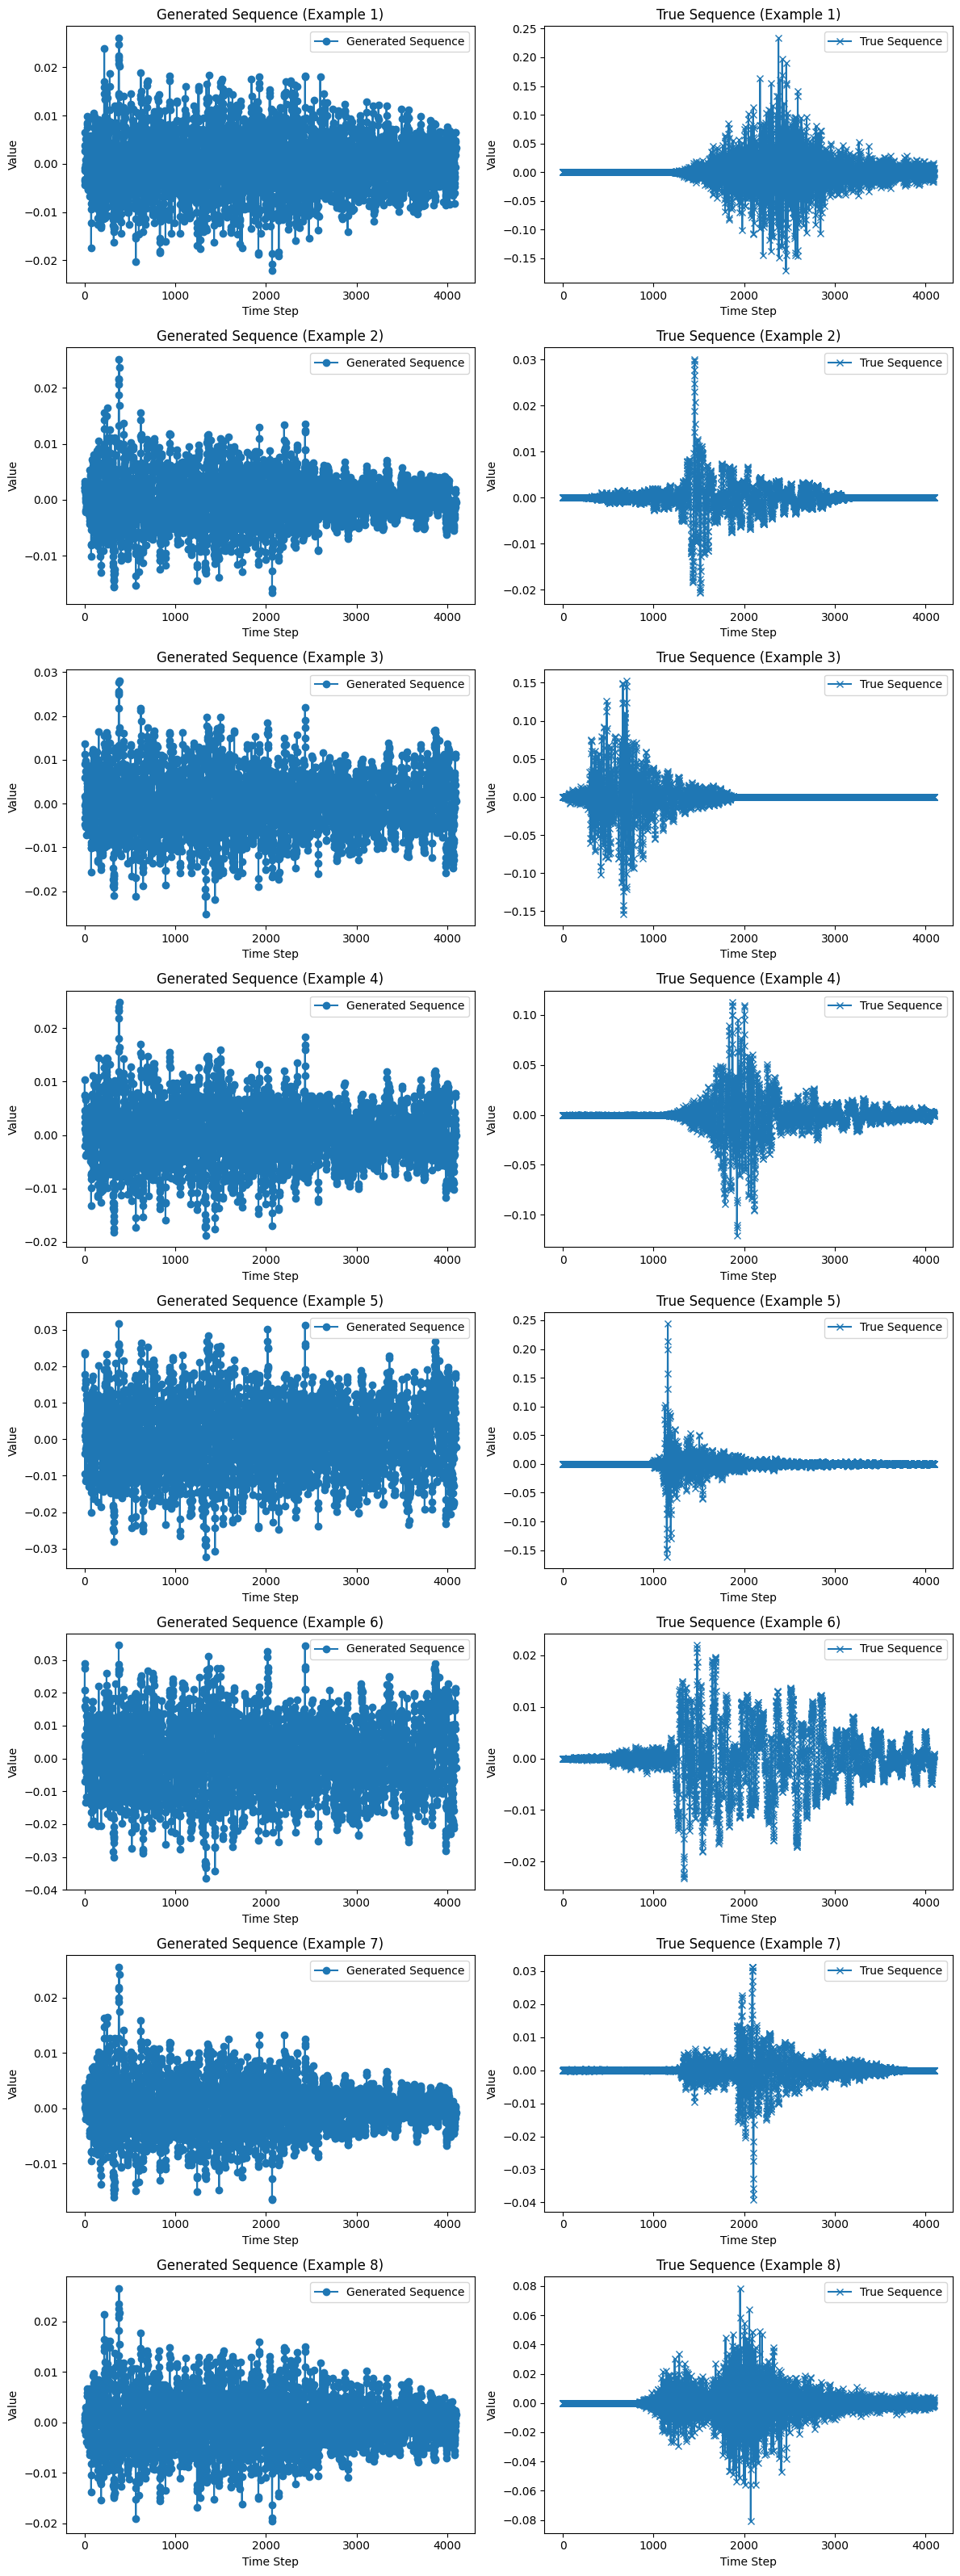

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

# Number of examples to plot
num_examples = 8

# Create a figure and subplots
fig, axes = plt.subplots(num_examples, 2, figsize=(12, 4 * num_examples))

# Iterate through the examples
for i in range(num_examples):
    # Select a random example from the test set
    example_index = np.random.randint(0, len(xTest))
    test_input = np.reshape(xTest[example_index, :], (1, 93))
    generated_sequence = loaded_model.predict(test_input)

    # Plot the generated sequence
    axes[i, 0].plot(generated_sequence[0, 0, :], label='Generated Sequence', marker='o')
    axes[i, 0].set_title(f"Generated Sequence (Example {i+1})")
    axes[i, 0].set_xlabel("Time Step")
    axes[i, 0].set_ylabel("Value")
    axes[i, 0].legend()

    # Plot the true sequence
    axes[i, 1].plot(yTest[example_index, :], label='True Sequence', marker='x')
    axes[i, 1].set_title(f"True Sequence (Example {i+1})")
    axes[i, 1].set_xlabel("Time Step")
    axes[i, 1].set_ylabel("Value")
    axes[i, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [28]:
#Calculate evaluation metrics Test Set
raw_output = loaded_model.predict(xTest)
output = np.reshape(raw_output, (2698, 4096))
final = yTest
print(output.shape, final.shape)
ariasAvg=np.mean(ariasNP(output,final))
spectrumAvg=np.mean(spectrumNP(output,final))
smAvg=0
i=0
while i<output.shape[0]:
    smAvg+=smearedNP(output[i,:],final[i,:])
    i+=1
smAvg/=i
print("Arias error ",ariasAvg)
print("Spectrum error ",spectrumAvg)
print("Smeared motion error ",smAvg)
print("\nTotal error ",ariasAvg+spectrumAvg+smAvg)

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
(2698, 4096) (2698, 4096)
Arias error  2.974257037740181
Spectrum error  0.6783144
Smeared motion error  1.0094994294139188

Total error  4.662070854952409


In [29]:
#Calculate evaluation metrics, Train Set
raw_output = loaded_model.predict(xTrain)
output = np.reshape(raw_output, (51261, 4096))
final = yTrain
print(output.shape, final.shape)
ariasAvg=np.mean(ariasNP(output,final))
spectrumAvg=np.mean(spectrumNP(output,final))
smAvg=0
i=0
while i<output.shape[0]:
    smAvg+=smearedNP(output[i,:],final[i,:])
    i+=1
smAvg/=i
print("Arias error ",ariasAvg)
print("Spectrum error ",spectrumAvg)
print("Smeared motion error ",smAvg)
print("\nTotal error ",ariasAvg+spectrumAvg+smAvg)

1602/1602 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
(51261, 4096) (51261, 4096)
Arias error  3.1084327513888397
Spectrum error  0.6808305
Smeared motion error  1.0055355698316821

Total error  4.794798799888735
